In [32]:
# Imports & Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from collections import defaultdict

plt.style.use("seaborn-v0_8")
np.random.seed(42)

# Load Raw Dataset
DATA_PATH = "fight_data_raw.csv"

df_raw = pd.read_csv(DATA_PATH)

print("Shape:", df_raw.shape)
print("Columns:")
print(df_raw.columns)

df_raw.head()

Shape: (8512, 38)
Columns:
Index(['UFC_Page', 'cards', 'date', 'fights', 'fighter_1_Fighter',
       'fighter_1_KD', 'fighter_1_Sig_Strike_Landed',
       'fighter_1_Sig_Strike_Attempts', 'fighter_1_Sig_Strike_Percent',
       'fighter_1_Strike_Landed', 'fighter_1_Strike_Attempts',
       'fighter_1_TD_Landed', 'fighter_1_TD_Attempts', 'fighter_1_TD_Percent',
       'fighter_1_Sub_Attempts', 'fighter_1_Pass', 'fighter_1_Rev',
       'fighter_2_Fighter', 'fighter_2_KD', 'fighter_2_Sig_Strike_Landed',
       'fighter_2_Sig_Strike_Attempts', 'fighter_2_Sig_Strike_Percent',
       'fighter_2_Strike_Landed', 'fighter_2_Strike_Attempts',
       'fighter_2_TD_Landed', 'fighter_2_TD_Attempts', 'fighter_2_TD_Percent',
       'fighter_2_Sub_Attempts', 'fighter_2_Pass', 'fighter_2_Rev', 'method',
       'round_finished', 'time', 'time_format', 'referee', 'fighter_1_res',
       'fighter_2_res', 'weight_class'],
      dtype='object')


,UFC_Page,cards,date,fights,fighter_1_Fighter,fighter_1_KD,fighter_1_Sig_Strike_Landed,fighter_1_Sig_Strike_Attempts,fighter_1_Sig_Strike_Percent,fighter_1_Strike_Landed,...,fighter_2_Pass,fighter_2_Rev,method,round_finished,time,time_format,referee,fighter_1_res,fighter_2_res,weight_class
0,http://ufcstats.com/statistics/events/complete...,http://ufcstats.com/event-details/c337c3c85b18...,7-Feb-26,http://ufcstats.com/fight-details/fb4b1754d510...,Mario Bautista,0,15,27,0.55,49,...,0,NaN,Submission,2,4:46,5 Rnd (5-5-5-5-5),Herb Dean,W,L,Bantamweight Bout
1,http://ufcstats.com/statistics/events/complete...,http://ufcstats.com/event-details/c337c3c85b18...,7-Feb-26,http://ufcstats.com/fight-details/dbbf8334a260...,Amir Albazi,0,16,67,0.23,20,...,0,NaN,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Keith Peterson,L,W,Flyweight Bout
2,http://ufcstats.com/statistics/events/complete...,http://ufcstats.com/event-details/c337c3c85b18...,7-Feb-26,http://ufcstats.com/fight-details/a5c5f76cf0a7...,Jailton Almeida,0,31,67,0.46,50,...,0,NaN,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Dan Miragliotta,L,W,Heavyweight Bout
3,http://ufcstats.com/statistics/events/complete...,http://ufcstats.com/event-details/c337c3c85b18...,7-Feb-26,http://ufcstats.com/fight-details/8fea32ab0445...,Michal Oleksiejczuk,0,140,221,0.63,143,...,0,NaN,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Chris Tognoni,W,L,Middleweight Bout
4,http://ufcstats.com/statistics/events/complete...,http://ufcstats.com/event-details/c337c3c85b18...,7-Feb-26,http://ufcstats.com/fight-details/2a26c0cfa062...,Jean Matsumoto,0,76,220,0.34,111,...,1,NaN,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,L,W,Bantamweight Bout


In [31]:
# CLEAN DATASET 
df = df_raw.copy()

# Replace NaN TD Percent with 0
df["fighter_1_TD_Percent"] = df["fighter_1_TD_Percent"].fillna(0)
df["fighter_2_TD_Percent"] = df["fighter_2_TD_Percent"].fillna(0)

# Remove Rev columns
df = df.drop(columns=["fighter_1_Rev", "fighter_2_Rev"], errors="ignore")

# Clean Weight Class Names
def clean_weight_class(wc):
    if pd.isna(wc):
        return "Unknown"

    wc = wc.lower()
    # Women's divisions
    if "women" in wc:
        if "straw" in wc:
            return "W_Strawweight"
        if "fly" in wc:
            return "W_Flyweight"
        if "bantam" in wc:
            return "W_Bantamweight"
        if "feather" in wc:
            return "W_Featherweight"
    
    # Men's divisions
    if "fly" in wc:
        return "Flyweight"
    if "bantam" in wc:
        return "Bantamweight"
    if "feather" in wc:
        return "Featherweight"
    if "lightweight" in wc:
        return "Lightweight"
    if "welter" in wc:
        return "Welterweight"
    if "middle" in wc:
        return "Middleweight"
    if "light heavy" in wc:
        return "Light_Heavyweight"
    if "heavyweight" in wc:
        return "Heavyweight"
    if "catch" in wc:
        return "Catchweight"
    if "open" in wc:
        return "Openweight"
    return "Other"

df["weight_class"] = df["weight_class"].apply(clean_weight_class)

# Convert date 
df["date"] = pd.to_datetime(df["date"], format="%d-%b-%y", errors="coerce")

df = df[df["date"].notna()]

# Remove No Contests and Draws
df = df[
    (df["fighter_1_res"].isin(["W", "L"])) &
    (df["fighter_2_res"].isin(["W", "L"]))
]

# Standardize fighter names
df["fighter_1_Fighter"] = df["fighter_1_Fighter"].str.strip()
df["fighter_2_Fighter"] = df["fighter_2_Fighter"].str.strip()

# Create Binary Outcome
df["F1_win"] = (df["fighter_1_res"] == "W").astype(int)



df.to_csv("fight_data.csv", index=False)

print("Clean dataset saved as fight_data.csv")
print("Final shape:", df.shape)


Clean dataset saved as fight_data.csv
Final shape: (8361, 37)


In [33]:
# Load Clean Dataset
df = pd.read_csv("fight_data.csv")

print("Shape:", df.shape)
print("\nColumns:\n", df.columns)
df.head()

Shape: (8361, 37)

Columns:
 Index(['UFC_Page', 'cards', 'date', 'fights', 'fighter_1_Fighter',
       'fighter_1_KD', 'fighter_1_Sig_Strike_Landed',
       'fighter_1_Sig_Strike_Attempts', 'fighter_1_Sig_Strike_Percent',
       'fighter_1_Strike_Landed', 'fighter_1_Strike_Attempts',
       'fighter_1_TD_Landed', 'fighter_1_TD_Attempts', 'fighter_1_TD_Percent',
       'fighter_1_Sub_Attempts', 'fighter_1_Pass', 'fighter_2_Fighter',
       'fighter_2_KD', 'fighter_2_Sig_Strike_Landed',
       'fighter_2_Sig_Strike_Attempts', 'fighter_2_Sig_Strike_Percent',
       'fighter_2_Strike_Landed', 'fighter_2_Strike_Attempts',
       'fighter_2_TD_Landed', 'fighter_2_TD_Attempts', 'fighter_2_TD_Percent',
       'fighter_2_Sub_Attempts', 'fighter_2_Pass', 'method', 'round_finished',
       'time', 'time_format', 'referee', 'fighter_1_res', 'fighter_2_res',
       'weight_class', 'F1_win'],
      dtype='object')


,UFC_Page,cards,date,fights,fighter_1_Fighter,fighter_1_KD,fighter_1_Sig_Strike_Landed,fighter_1_Sig_Strike_Attempts,fighter_1_Sig_Strike_Percent,fighter_1_Strike_Landed,...,fighter_2_Pass,method,round_finished,time,time_format,referee,fighter_1_res,fighter_2_res,weight_class,F1_win
0,http://ufcstats.com/statistics/events/complete...,http://ufcstats.com/event-details/c337c3c85b18...,2026-02-07,http://ufcstats.com/fight-details/fb4b1754d510...,Mario Bautista,0,15,27,0.55,49,...,0,Submission,2,4:46,5 Rnd (5-5-5-5-5),Herb Dean,W,L,Bantamweight,1
1,http://ufcstats.com/statistics/events/complete...,http://ufcstats.com/event-details/c337c3c85b18...,2026-02-07,http://ufcstats.com/fight-details/dbbf8334a260...,Amir Albazi,0,16,67,0.23,20,...,0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Keith Peterson,L,W,Flyweight,0
2,http://ufcstats.com/statistics/events/complete...,http://ufcstats.com/event-details/c337c3c85b18...,2026-02-07,http://ufcstats.com/fight-details/a5c5f76cf0a7...,Jailton Almeida,0,31,67,0.46,50,...,0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Dan Miragliotta,L,W,Heavyweight,0
3,http://ufcstats.com/statistics/events/complete...,http://ufcstats.com/event-details/c337c3c85b18...,2026-02-07,http://ufcstats.com/fight-details/8fea32ab0445...,Michal Oleksiejczuk,0,140,221,0.63,143,...,0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Chris Tognoni,W,L,Middleweight,1
4,http://ufcstats.com/statistics/events/complete...,http://ufcstats.com/event-details/c337c3c85b18...,2026-02-07,http://ufcstats.com/fight-details/2a26c0cfa062...,Jean Matsumoto,0,76,220,0.34,111,...,1,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,L,W,Bantamweight,0


In [38]:
# Checking sanity
print("Date range:", df["date"].min(), "to", df["date"].max())

print("Total fights:", len(df))

fighters = pd.concat([df["fighter_1_Fighter"], df["fighter_2_Fighter"]]).unique()
print("Total fighters:", len(fighters))

print("\nWeight classes:")
print(df["weight_class"].value_counts())


Date range: 1994-03-11 to 2026-02-07
Total fights: 8361
Total fighters: 2629

Weight classes:
weight_class
Lightweight          1402
Welterweight         1360
Middleweight         1106
Featherweight         822
Bantamweight          743
Heavyweight           743
Light_Heavyweight     726
Flyweight             397
W_Strawweight         357
W_Flyweight           264
W_Bantamweight        235
Openweight             86
Catchweight            77
W_Featherweight        30
Other                  13
Name: count, dtype: int64


In [36]:
# Prepare For Modeling Dataset
df_model = df[[
    "date",
    "fighter_1_Fighter",
    "fighter_2_Fighter",
    "F1_win",
    "weight_class"
]].copy()

df_model = df_model.rename(columns={
    "fighter_1_Fighter": "Fighter1",
    "fighter_2_Fighter": "Fighter2"
})

df_model["date"] = pd.to_datetime(df_model["date"])

df_model = df_model.sort_values("date", ascending=False).reset_index(drop=True)

df_model.head()

,date,Fighter1,Fighter2,F1_win,weight_class
0,2026-02-07,Mario Bautista,Vinicius Oliveira,1,Bantamweight
1,2026-02-07,Nikolay Veretennikov,Niko Price,1,Welterweight
2,2026-02-07,Amir Albazi,Kyoji Horiguchi,0,Flyweight
3,2026-02-07,Klaudia Sygula,Priscila Cachoeira,1,W_Bantamweight
4,2026-02-07,Muin Gafurov,Jakub Wiklacz,0,Bantamweight


In [40]:
# Bayesian Model Class (Bayesian Bradley–Terry)
from scipy.optimize import minimize

class BayesianUFCSkillModel:
    
    def __init__(self, prior_std=1.0):
        self.prior_var = prior_std ** 2
        self.fighter_to_idx = {}
        self.idx_to_fighter = {}
        self.skills = None
        
    def _log_posterior(self, skills, i_idx, j_idx, outcomes):
        
        diff = skills[i_idx] - skills[j_idx]
        prob = 1 / (1 + np.exp(-diff))
        
        log_likelihood = np.sum(
            outcomes * np.log(prob + 1e-10) +
            (1 - outcomes) * np.log(1 - prob + 1e-10)
        )
        
        log_prior = -0.5 * np.sum(skills**2 / self.prior_var)
        
        return -(log_prior + log_likelihood)
    
    
    def fit(self, df):
        
        fighters = pd.concat([df["Fighter1"], df["Fighter2"]]).unique()
        self.fighter_to_idx = {f: i for i, f in enumerate(fighters)}
        self.idx_to_fighter = {i: f for f, i in self.fighter_to_idx.items()}
        
        i_idx = df["Fighter1"].map(self.fighter_to_idx).values
        j_idx = df["Fighter2"].map(self.fighter_to_idx).values
        outcomes = df["F1_win"].values
        
        initial_skills = np.zeros(len(fighters))
        
        result = minimize(
            self._log_posterior,
            initial_skills,
            args=(i_idx, j_idx, outcomes),
            method="L-BFGS-B"
        )
        
        self.skills = result.x
        self.skills -= np.mean(self.skills)
    
    
    def predict_proba(self, fighter1, fighter2):
        
        s1 = self.skills[self.fighter_to_idx[fighter1]] \
            if fighter1 in self.fighter_to_idx else 0
        
        s2 = self.skills[self.fighter_to_idx[fighter2]] \
            if fighter2 in self.fighter_to_idx else 0
        
        return 1 / (1 + np.exp(-(s1 - s2)))


In [41]:
# Train Per Weight Class

models_by_weight = {}
rankings_by_weight = {}

for wc in df_model["weight_class"].unique():
    
    df_wc = df_model[df_model["weight_class"] == wc]
    
    if len(df_wc) < 100:
        continue
    
    model = BayesianUFCSkillModel(prior_std=1.0)
    model.fit(df_wc)
    
    models_by_weight[wc] = model
    
    ranking = sorted(
        [(model.idx_to_fighter[i], s) for i, s in enumerate(model.skills)],
        key=lambda x: x[1],
        reverse=True
    )
    
    rankings_by_weight[wc] = ranking

print("Models trained for", len(models_by_weight), "weight classes.")


Models trained for 11 weight classes.


In [44]:
from collections import defaultdict

accuracy_by_weight = {}
logloss_by_weight = {}

for wc in df_model["weight_class"].unique():
    
    df_wc = df_model[df_model["weight_class"] == wc].sort_values("date")
    
    if len(df_wc) < 200:
        continue
    
    split = int(0.8 * len(df_wc))
    train = df_wc.iloc[:split]
    test = df_wc.iloc[split:]
    
    model = BayesianUFCSkillModel(prior_std=1.0)
    model.fit(train)
    
    correct = 0
    logloss = 0
    
    for _, row in test.iterrows():
        
        prob = model.predict_proba(row["Fighter1"], row["Fighter2"])
        y = row["F1_win"]
        
        pred = 1 if prob > 0.5 else 0
        if pred == y:
            correct += 1
            
        logloss += -(y*np.log(prob+1e-10) + (1-y)*np.log(1-prob+1e-10))
    
    accuracy_by_weight[wc] = correct / len(test)
    logloss_by_weight[wc] = logloss / len(test)

accuracy_by_weight


{'Bantamweight': 0.5436241610738255,
 'Welterweight': 0.43014705882352944,
 'Flyweight': 0.6625,
 'W_Bantamweight': 0.2765957446808511,
 'W_Strawweight': 0.4583333333333333,
 'Light_Heavyweight': 0.410958904109589,
 'Middleweight': 0.4594594594594595,
 'Heavyweight': 0.5100671140939598,
 'Featherweight': 0.5454545454545454,
 'Lightweight': 0.5302491103202847,
 'W_Flyweight': 0.5660377358490566}

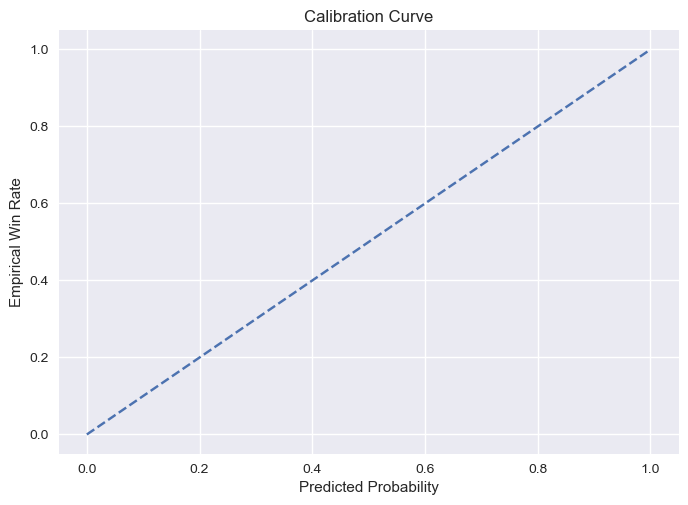

In [50]:
import matplotlib.pyplot as plt

def calibration_plot(model, test_df, bins=10):
    
    probs = []
    outcomes = []
    
    for _, row in test_df.iterrows():
        probs.append(model.predict_proba(row["Fighter1"], row["Fighter2"]))
        outcomes.append(row["F1_win"])
    
    probs = np.array(probs)
    outcomes = np.array(outcomes)
    
    bin_edges = np.linspace(0, 1, bins+1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    empirical = []
    
    for i in range(bins):
        mask = (probs >= bin_edges[i]) & (probs < bin_edges[i+1])
        if np.sum(mask) > 0:
            empirical.append(np.mean(outcomes[mask]))
        else:
            empirical.append(np.nan)
    plt.plot(bin_centers, empirical, marker='o')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Win Rate")
plt.title("Calibration Curve")
plt.show()

In [54]:
# Dynamic Skill Model
import numpy as np
from collections import defaultdict

class DynamicUFCSkillModel:
    
    def __init__(self, 
                 init_mu=0.0,
                 init_sigma=1.0,
                 performance_sigma=1.0,
                 drift_per_year=0.3):
        
        self.init_mu = init_mu
        self.init_sigma = init_sigma
        self.performance_sigma = performance_sigma
        self.drift_per_year = drift_per_year
        
        self.mu = defaultdict(lambda: init_mu)
        self.sigma2 = defaultdict(lambda: init_sigma**2)
        self.last_fight_date = {}
    
    def _apply_time_drift(self, fighter, current_date):
        
        if fighter not in self.last_fight_date:
            self.last_fight_date[fighter] = current_date
            return
        
        days = (current_date - self.last_fight_date[fighter]).days
        years = days / 365.25
        
        self.sigma2[fighter] += (self.drift_per_year * years)**2
        
        self.last_fight_date[fighter] = current_date
    
    
    def update(self, fighter1, fighter2, winner, date):
        
        # apply drift
        self._apply_time_drift(fighter1, date)
        self._apply_time_drift(fighter2, date)
        
        mu1 = self.mu[fighter1]
        mu2 = self.mu[fighter2]
        
        sigma1 = np.sqrt(self.sigma2[fighter1])
        sigma2 = np.sqrt(self.sigma2[fighter2])
        
        c2 = sigma1**2 + sigma2**2 + 2*self.performance_sigma**2
        c = np.sqrt(c2)
        
        expected1 = 1 / (1 + np.exp(-(mu1 - mu2)/c))
        
        score1 = 1 if winner == fighter1 else 0
        
        # update means
        delta = (score1 - expected1)
        
        self.mu[fighter1] += (sigma1**2 / c) * delta
        self.mu[fighter2] -= (sigma2**2 / c) * delta
        
        # update variances
        self.sigma2[fighter1] = max(self.sigma2[fighter1] * 0.99, 0.1)
        self.sigma2[fighter2] = max(self.sigma2[fighter2] * 0.99, 0.1)

        
    def fit(self, df):    
        df = df.sort_values("date")
        for _, row in df.iterrows():
            
            f1 = row["Fighter1"]
            f2 = row["Fighter2"]
            winner = f1 if row["F1_win"] == 1 else f2
            date = row["date"]
            
            self.update(f1, f2, winner, date)

    def predict_proba(self, fighter1, fighter2):

        mu1 = self.mu[fighter1]
        mu2 = self.mu[fighter2]
    
        sigma1 = np.sqrt(self.sigma2[fighter1])
        sigma2 = np.sqrt(self.sigma2[fighter2])
    
        denom = np.sqrt(sigma1**2 + sigma2**2 + self.performance_sigma**2)
    
        return 1 / (1 + np.exp(-(mu1 - mu2) / denom))


In [56]:
df_model = df_model.sort_values("date").reset_index(drop=True)

model = DynamicUFCSkillModel(
    init_mu=0.0,
    init_sigma=1.0,
    performance_sigma=0.5,
    drift_per_year=0.5
)

correct = 0
total = 0

split = int(0.8 * len(df_model))

for i, row in df_model.iterrows():

    f1 = row["Fighter1"]
    f2 = row["Fighter2"]
    winner = f1 if row["F1_win"] == 1 else f2
    date = row["date"]

    # Only evaluate AFTER training portion
    if i >= split:
        prob = model.predict_proba(f1, f2)
        pred = 1 if prob > 0.5 else 0

        if pred == row["F1_win"]:
            correct += 1

        total += 1

    # Update happens AFTER prediction
    model.update(f1, f2, winner, date)

accuracy = correct / total
accuracy


0.56246264196055